In this Jupyter Notebook, we will study the US unemployment rate between 1996 and 2000.  We will use a Python ARIMA model to generate a predictor and plot our predictor vs the actual time series.

The process we will follow:
1. Load and filter our data
2. Use the Augmented Dickey-Fuller test to calculate the number of times we need to differenciate (if any) to eliminate trends in our data.
3. We will iteratively test SARIMAX models from statsmodels to finde the parameters of our ARMA model.  We will try to minimize AIC/BIC to find the best values
4. With the parameters found in 2 and 3, we will fit our time series and predict values for the last 20 months of the series.
5. We will plot the predictions vs the actual time series

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [12]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

First things first, we load our data and filter the period that we will study in this notebook.

The US unemployment data was downloaded from https://fred.stlouisfed.org/.  

In [2]:
# Load Unemployment rate
uen = pd.read_csv('UNRATE.csv', parse_dates=True, index_col='DATE')
uen = uen['1996-01-01':'2000-12-31'].dropna()

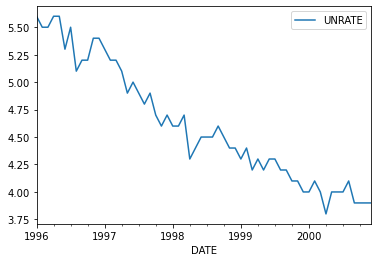

In [3]:
uen.plot()
plt.show()

We get the number of differencing needed using the Augmented Dickey-Fuller test. 

In [4]:
# Import adfuller from statsmodels
from statsmodels.tsa.stattools import adfuller

In [5]:
# Get the differencing
adf = adfuller(uen.iloc[:, 0])
print('ADF Statistic:', adf[0])
print('p-value:', adf[1])

# First differencing
adf = adfuller(uen.diff().dropna().iloc[:,0])
print('1st differencing ADF Statistic:', adf[0])
print('1st differencing p-value:', adf[1])

# Second differencing
adf = adfuller(uen.diff().diff().dropna().iloc[:,0])
print('1st differencing ADF Statistic:', adf[0])
print('1st differencing p-value:', adf[1])

ADF Statistic: -1.2175874754792062
p-value: 0.6659846372269607
1st differencing ADF Statistic: -7.716175607974027
1st differencing p-value: 1.2265857589437795e-11
1st differencing ADF Statistic: -4.516761281254484
1st differencing p-value: 0.0001833724487189293


Our p-value after a 1st difference is less than 0.05, so first differencing is enough for this data.

The next step, we get the best ARMA parameters with AIC/BIC.

So, we loop AIC / BIC models, trying to find the one that minimizes both.

In [6]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [13]:
# Initialize list
order_aic_bic = []
# Loop over p values from 0-3
for p in range(4):
    # Loop over q values from 0-3
    for q in range(4):
        try:
            # create and fit ARMA(p,q) model
            model = SARIMAX(uen['UNRATE'], order=(p, 2, q))
            # model = SARIMAX(uen, order=(p, 1, q), trend='c') #if constant trend
            results = model.fit()
            # Append order and results tuple
            order_aic_bic.append((p, q, results.aic, results.bic))
        except:
            order_aic_bic.append((p, q, None, None))

Once we have the list with different combinations of AIC/BIC, we print in ascending order to get the ideal values for our model.

In [8]:
# Construct DataFrame from order_aic_bic
order_df = pd.DataFrame(order_aic_bic,
                        columns=['p', 'q', 'AIC', 'BIC'])
# Print order_df in order of increasing AIC and BIC and choose the minimum
print(order_df.sort_values('AIC'))
print(order_df.sort_values('BIC'))

    p  q        AIC        BIC
2   0  2 -77.018022 -70.836693
6   1  2 -75.257282 -67.015510
3   0  3 -75.154828 -66.913056
9   2  1 -74.055303 -65.813531
5   1  1 -73.921403 -67.740074
7   1  3 -73.111927 -62.809712
15  3  3 -72.576559 -58.153458
10  2  2 -72.061873 -61.759658
13  3  1 -72.053173 -61.750958
14  3  2 -70.081913 -57.719255
11  2  3 -69.900187 -57.537529
1   0  1 -63.942888 -59.822002
12  3  0 -57.029137 -48.787365
8   2  0 -55.519890 -49.338561
4   1  0 -39.926185 -35.805299
0   0  0  -8.572776  -6.512333
    p  q        AIC        BIC
2   0  2 -77.018022 -70.836693
5   1  1 -73.921403 -67.740074
6   1  2 -75.257282 -67.015510
3   0  3 -75.154828 -66.913056
9   2  1 -74.055303 -65.813531
7   1  3 -73.111927 -62.809712
10  2  2 -72.061873 -61.759658
13  3  1 -72.053173 -61.750958
1   0  1 -63.942888 -59.822002
15  3  3 -72.576559 -58.153458
14  3  2 -70.081913 -57.719255
11  2  3 -69.900187 -57.537529
8   2  0 -55.519890 -49.338561
12  3  0 -57.029137 -48.787365
4   1  0

Both AIC and BIC give us the same parameters for our model.  We will therefore use an ARMA(0, 2) model.

Then, we input the calculated values and get our model.

In [14]:
model = SARIMAX(uen, order=(0, 2, 2), trend='c')
results = model.fit()

In [10]:
# Make in-sample prediction
forecast = results.get_prediction(start=-20, dynamic=True)

Great! Now that we have the forecast, we print its mean and the confidence interval vs. the actual series to illustrate the accuracy of our model.

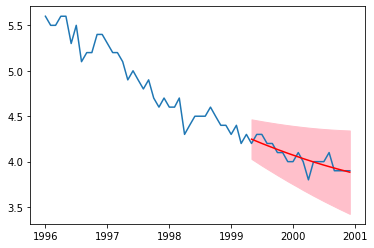

In [11]:
# Plot prediction
plt.plot(uen.index, uen.values)
plt.plot(forecast.predicted_mean.index,
         forecast.predicted_mean.values,
         color='red',
         label='forecast')
# Shade confidence interval
test = forecast.conf_int()
lower_limits = test.iloc[:, 0]
upper_limits = test.iloc[:, 1]
plt.fill_between(lower_limits.index, lower_limits, upper_limits, color='pink')

plt.show() 

Our predictor is not too bad!